# DNBLab Tutorial: Daten bereinigen und zusammenführen mittels OpenRefine

## Part 1: Datenbezug mittels SRU-Schnittstelle

Als Datenbasis dienen die Metadaten des Digitalisierungsprojektes "100 Bände Klassik". Es enthält namhafte klassische Werke u.a. von Theodor Fontane, J.W. von Goethe und Rainer Maria Rilke und eignet sich daher besonders für einen ersten Einstieg in die Datenanreicherung, da die AutorInnen bereits umfassende Einträge in der GND haben. 

Die Daten werden mittels SRU-Schnittstelle bezogen und zur weiteren Verarbeitung in einer csv-Datei gespeichert. 

## Einrichten der Arbeitsumgebung

Um die Arbeitsumgebung für die folgenden Schritte passend einzurichten, sollten zunächst die benötigten Python-Bibliotheken importiert werden. Für Anfragen über die SRU-Schnittstelle wird `Requests` https://docs.python-requests.org/en/latest/ und zur Verarbeitung der XML-Daten `etree` https://docs.python.org/3/library/xml.etree.elementtree.html verwendet. Mit `Pandas` https://pandas.pydata.org/ können Elemente aus dem MARC21-Format ausgelesen werden.

In [1]:
import requests
from bs4 import BeautifulSoup 
import unicodedata
from lxml import etree
import pandas as pd
import matplotlib.pyplot as plt

## SRU-Abfrage mit Ausgabe in MARC21-xml

Die Funktion `dnb_sru` nimmt den Paramter "query" der SRU-Abfrage entgegen und liefert alle Ergebnisse als eine Liste von Records aus. Bei mehr als 100 Records werden weitere Datensätze mit "&startRecord=101" abgerufen (mögliche Werte 1 bis 99.000). Weitere Informationen und Funktionen der SRU- Schnittstelle werden unter https://www.dnb.de/sru beschrieben.

In [2]:
def dnb_sru(query):
    base_url = "https://services.dnb.de/sru/dnb"
    params = {
        'recordSchema': 'MARC21-xml',
        'operation': 'searchRetrieve',
        'version': '1.1',
        'maximumRecords': '100',
        'query': query
    }

    r = requests.get(base_url, params=params)
    # Verwende den XML-Parser
    xml = BeautifulSoup(r.content, features="xml")
    records = xml.find_all('record', {'type': 'Bibliographic'})

    if len(records) < 100:
        return records
    else:
        num_records_fetched = 100  # Anzahl der abgerufenen Datensätze
        start_record = 101  # Startindex für die nächste Abfrage
        while num_records_fetched == 100:
            params.update({'startRecord': start_record})
            r = requests.get(base_url, params=params)
            # Verwende den XML-Parser 
            xml = BeautifulSoup(r.content, features="xml")
            new_records = xml.find_all('record', {'type': 'Bibliographic'})
            records += new_records
            start_record += 100
            num_records_fetched = len(new_records)

        return records

# Durchsuchen eines MARC-Feldes

Die Funktion `parse_records` nimmt als Parameter jeweils ein Record entgegen und sucht über xpath die gewünschte Informationen heraus und liefert diese als Dictionary zurück. Die Schlüssel-Werte-Paare können beliebig angepasst und erweitert werden. 

Tipp: Schauen Sie sich gern unsere Feldübersicht für MARC21 an. 
https://www.dnb.de/SharedDocs/Downloads/DE/Professionell/Services/efa2023HandoutInhalteInMarc.pdf?__blob=publicationFile&v=2 

In [3]:
def parse_record(record):
    ns = {"marc": "http://www.loc.gov/MARC21/slim"}
    xml = etree.fromstring(unicodedata.normalize("NFC", str(record)))

    def safe_xpath(xpath_expr):
        elements = xml.xpath(xpath_expr, namespaces=ns)
        return elements[0].text if elements else "unknown"

    # IDN
    idn = safe_xpath("marc:controlfield[@tag = '001']")

    # Titel
    titel = safe_xpath("marc:datafield[@tag = '245']/marc:subfield[@code = 'a']")

    # Erscheinungsjahr
    jahr = safe_xpath("marc:datafield[@tag = '264']/marc:subfield[@code = 'c']")

    # Verfasserangabe
    verfasser = safe_xpath("marc:datafield[@tag = '100']/marc:subfield[@code = 'a']")

    # GND-ID
    gnd_id = safe_xpath("marc:datafield[@tag = '100']/marc:subfield[@code = '0']")

    # URN
    urn = safe_xpath("marc:datafield[@tag = '856']/marc:subfield[@code = 'u']")

    # Verlag
    verlag = safe_xpath("marc:datafield[@tag = '264']/marc:subfield[@code = 'b']")

    # Verlagsort
    verlagsort = safe_xpath("marc:datafield[@tag = '264']/marc:subfield[@code = 'a']")

    meta_dict = {
        "idn": idn,
        "titel": titel,
        "jahr": jahr,
        "verfasser": verfasser,
        "gnd_id": gnd_id,
        "urn": urn,
        "verlag": verlag,
        "verlagsort": verlagsort
    }

    return meta_dict


Das Digitalisierungsprojekt "100 Bände Klassik" kann mt dem Projektcode "d002" als Datenset abgefragt und die Ergebnismenge ausgegeben werden.

In [4]:
records = dnb_sru('cod=d002')
print(len(records), 'Ergebnisse')

108 Ergebnisse


## CSV Download

Für die Datenbereinigung und Datenanreicherung wird die Arbeit im csv-Format empfohlen. Hierfür werden die Suchergebnisse im Folgenden in einem Dataframe (Tabelle) ausgegeben und anschließend für die weitere Bearbeitung heruntergeladen. 

In [5]:
output = [parse_record(record) for record in records]
df = pd.DataFrame(output)
df

,idn,titel,jahr,verfasser,gnd_id,urn,verlag,verlagsort
0,1003104487,Egmont,[1946],"Goethe, Johann Wolfgang von",(DE-588)118540238,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Schöningh,Paderborn
1,999490184,Das Amulett,[1939],"Meyer, Conrad Ferdinand",(DE-588)118581775,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Verl. Dt. Volksbücher,Wiesbaden
2,1000047377,Der Struwwelpeter oder lustige Geschichten u...,[1939],"Hoffmann, Heinrich",(DE-588)11855249X,https://nbn-resolving.org/urn:nbn:de:101:2-201...,[Loewe],[Stuttgart]
3,1000290328,Der Zweikampf,1939,"Kleist, Heinrich von",(DE-588)118563076,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Kohlhammer,Stuttgart
4,99962461X,Heidi,1939,"Spyri, Johanna",(DE-588)118616455,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Rascher,Zürich
...,...,...,...,...,...,...,...,...
103,1000746348,Leyer und Schwerdt,1913,"Körner, Theodor",(DE-588)118713507,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Morawe & Scheffelt,Berlin
104,100003917X,Schillers Wallenstein,[1913],"Schiller, Friedrich",(DE-588)118607626,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Dt. Bibliothek,Berlin
105,1000062104,Vor dem Sturm,1913,"Fontane, Theodor",(DE-588)118534262,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Cotta,Stuttgart
106,1000775615,Der Tod des Tizian,[1912],"Hofmannsthal, Hugo von",(DE-588)118552759,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Insel-Verl.,Leipzig


In [6]:
# DataFrame als CSV speichern
df.to_csv('Klassik.csv', index=False)

# Part 2: Datenbereinigung 

In unserer Ausgabe fällt auf, dass viele Titel mit eckigen Klammern ausgegeben werden oder zusätzliche Informationen enthalten, die nicht für die Analysen relevant sind. Grundlage für jede Datenanalyse sind normierte und bereinigte Ausgangsdaten. Diese können wir mittels OpenRefine bereinigen. OpenRefine ist ein Tool zur Datenbereinigung und Datenaufbereitung. Es kann mit sehr großen Datenmengen und mit diversen Formaten umgehen, zb.: .csv, .xml, .json etc. und eignet sich somit gut für die Analyse unserer Metadaten. 

Für die Datenbereinigung wird die Open-Source-Software OpenRefine eingesetzt. Eine lokale Installation (https://openrefine.org/download) wird empfohlen. Alternativ kann OpenRefine in der Webumgebung Binder gestartet werden: https://mybinder.org/v2/gh/innovationOUtside/nb_serverproxy_openrefine/main?urlpath=openrefine 

Bitte beachten Sie, dass die Ladezeiten der Online-Instanz stark variieren können.

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/1_Datenimport.png)

Folgende Felder sollen für eine exemplarische Analyse bereinigt werden. Dafür nutzen wir GREL-Funktionen, um die Werte zu extrahieren. GREL-Funktionen arbeiten mit regulären Ausdrücken. Die genauen Bezeichnungen kann man im Handbuch von OpenRefine nachlesen. "GREL" steht für "General Refine Expression Language" und bezieht sich auf die Ausdruckssprache, die in OpenRefine verwendet wird. Siehe: https://openrefine.org/docs/manual/grelfunctions 

**Erscheinungsjahr** 
- `value.find(/(\b\d{4}\b)/)[0]`
- Diese GREL-Funktion extrahiert das erste vierstellige Jahr, das in einer Zeichenkette gefunden wird. Dabei wird nach einer vierstelligen Zahl (z.B. "2024") gesucht und diese als Ergebnis zurückgegeben. 
- Hierfür wählen wir im Drop-Down Menü der Spalte den Befehl EDIT CELLS - Transform. Nun können wir unsere GREL-Expression eingeben. 







![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/2_Edit_Cells.JPG)

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/3_Year.png)


**GND ID** 
- `value.replace(/\(DE-588\)/, "").trim()`
- Diese GREL-Funktion entfernt den Text "(DE-588)" aus einer Zeichenkette und entfernt anschließend überflüssige Leerzeichen am Anfang oder Ende der Zeichenkette. Das Ergebnis ist die bereinigte GND-ID ohne den Präfix "(DE-588)".

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/4_GND.JPG)

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/5_GNDT.JPG)


**Verlagsort**

- Um die Verlagsorte zu bereinigen, nutzen wir eine andere Möglichkeit der Bearbeitung von Open Refine. Zuerst werden wir die Verlagsorte vorselektieren. Dieser Weg eignet sich besonders bei kleinen Datenmengen. 
- Wir wählen im Drop-Down-Menü das Feld `Facetten - Custom Facet`

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/6_Verlag.JPG)


- In einem Popup sehen wir nun eine Liste aller Verlagsorte. Diese bestätigen wir mit OK. 

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/7_customfacet.JPG)


- Daraufhin erscheint am linken Bildrand eine Liste. Wir suchen nun nach abweichenden Verlagsnamen und fügen sie mittels `include` zur Liste hinzu.


![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/8_Include.JPG)


- Die dadurch gebildete Facette sollte nun angezeigt werden.
- Mittels Mouse-Over und `Edit` gelangen wir zu dem einzelnen Value. 


![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/9_edit.JPG)


- Dieser wird nun in den bereinigten Verlagsort, zb.: Berlin umbenannt und mittels `Apply to all identical cells` wird jeder gleichnamige Value dieser Orte zu Berlin normiert. Diese Variante eignet sich bei überschaubaren Datenmengen.
- Zur Entfernung der Filter einfach `reset` in der rechten Spalte wählen 

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/10_apply.JPG)


# Part 3: Datenanreicherung mittels Open Refine

In der Gemeinsamen Normdatei (GND) finden wir viele Informationen zu Personen, Werken und Orten. Dort sind unter anderem Informationen zu Berufen, Beziehungen, Sterbe- und Geburtsdaten sowie Wirkungsdaten und Orte verzeichnet. Für unsere exemplarische Analyse reichern wir die Spalte `verfasser`mit Informationen aus der GND an. 

Folgende Felder sollen angereichert werden: 
- Geburtsdatum
- Geburtsort
- Liste der Berufe der Person

Weitere Felder. Informieren Sie sich dafür im GND Explorer und fügen Sie ein Feld Ihrer Wahl hinzu:  https://explore.gnd.network/

- Für die Datenanreicherung wählen wir die Spalte `gnd_id` 
- Unter dem Punkt `Reconcile` finden wir den Punkt `Start Reconciling`


![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/11_reconcile.JPG)

- Anschließend den Punkt `Add Standard Service` wählen
- Zum Abgleich nutzen wir `https://lobid.org/gnd/reconcile/`
- Mit `Add Service` bestätigen
- Fenster mit "Cancel" schließen

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/13_lobid.JPG)

- Nach dem Einrichten des Standard Service können wir nun über `Reconcile` `Use Values as Identifiers` die Verknüpfung mit der GND herstellen
- Wir wählen unseren Service `GND reconcililation  for OpenRefine`

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/14_values.JPG)

- Die Daten erscheinen nun als Links. Beim Mouse-Over werden Informationen über den Autor angezeigt.
- Um zusätzliche Spalten zu erstellen, wählen wir nun unsere Spalte `gnd_id` `Edit column` `Add column from reconciled values...` und können anschließend unsere gewünschten Werte wählen


![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/15_revalues.JPG)

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/16_new.JPG)

- `OK` anwählen und einen Moment warten, während Open Refine die neuen Spalten erstellt.
- Im Drop-Down Menü unter Exportieren kann die Datei als .csv Datei exportiert werden. 

## Part 4: Datenanalyse

## Daten einlesen

Nachdem die Daten bereinigt und mit Daten aus der GND angereichert wurden, führen wir eine exemplarische Analyse auf unseren angereicherten Daten durch. Zuerst wird die csv-Datei importiert und als Dataframe (Tabelle) ausgegeben. Der Dataframe bildet die Basis für die weiteren Bearbeitungen. 

Da die Zeilen in Open Refine untereinander angezeigt werden, findet sich bei leeren Werten die Bezeichnung "NaN".

In [8]:
# Passe den Dateinamen entsprechend an
filename = 'Klassik_angereichert.csv'

# Daten aus der CSV-Datei in DataFrame laden
df = pd.read_csv(filename)

df


,idn,titel,jahr,verfasser,gnd_id,Geburtsdatum,Geburtsort,Beruf oder Beschäftigung,Sterbeort,urn,verlag,verlagsort
0,1003104487,Egmont,1946.0,"Goethe, Johann Wolfgang von",118540238,1749-08-28,Frankfurt am Main,Schriftsteller,Weimar,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Schöningh,Paderborn
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Publizist,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Politiker,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jurist,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Naturwissenschaftler,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
618,1000778517,Die drei gerechten Kammacher,1903.0,"Keller, Gottfried",11856109X,1819-07-19,Zürich,Schriftsteller,Zürich,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Cotta,Stuttgart
619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Librettist,NaN,NaN,NaN,NaN
620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Maler,NaN,NaN,NaN,NaN
621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lyriker,NaN,NaN,NaN,NaN


## Vertretene AutorInnen

Zuerst soll herausgefunden werden, welche AutorInnen mit wie vielen Werken in dem Datenset vorhanden sind. Dazu zählen wir die values in dem gegebenen Dataframe.

In [9]:
# Anzahl der Werke pro AutorIn zählen und in ein DataFrame konvertieren
anzahl_werke_pro_autor_df = pd.DataFrame(df['verfasser'].value_counts())

# Umbenennen der Spalte in 'Anzahl der Werke'
anzahl_werke_pro_autor_df.columns = ['Anzahl der Werke']

# Anzeige des DataFrames
print("Anzahl der Werke pro AutorIn:")
print(anzahl_werke_pro_autor_df)

Anzahl der Werke pro AutorIn:
                                              Anzahl der Werke
verfasser                                                     
Kleist, Heinrich von                                       7
Goethe, Johann Wolfgang von                                6
Fontane, Theodor                                             6
Meyer, Conrad Ferdinand                                      5
Keller, Gottfried                                            5
Eichendorff, Joseph von                                    4
Storm, Theodor                                               4
Hoffmann, E. T. A.                                           4
Schiller, Friedrich                                          4
Stifter, Adalbert                                            3
Gotthelf, Jeremias                                           3
Mörike, Eduard                                               3
Wassermann, Jakob                                            3
Hofmannsthal, Hugo von 

## Erscheinungsjahre visualisieren 

Die Erscheinungsjahre der Publikationen sollen grafisch dargestellt werden.
Testen Sie, was passiert, wenn Sie die Werte unter plt.figure(figsize=(15, 8)) & plt.hist(years, bins=50, ändern. 

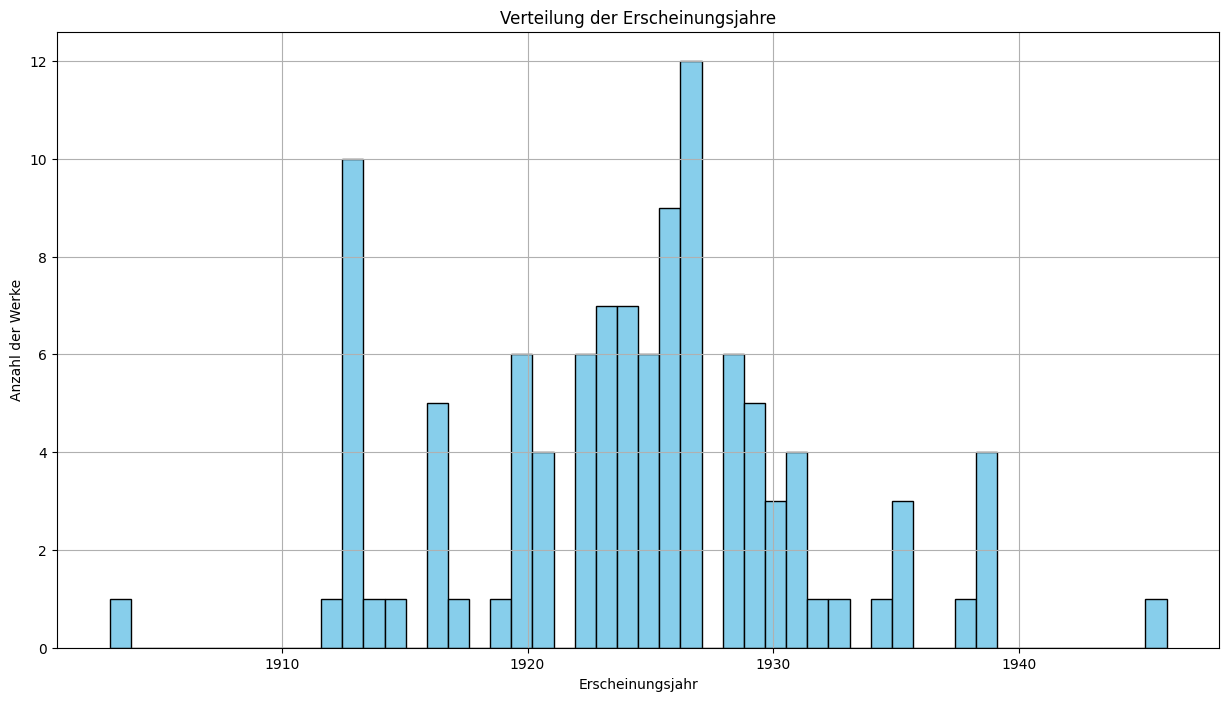

In [10]:
# Erscheinungsjahre aus der Spalte 'jahr' im DataFrame df extrahieren
years = df['jahr']

# Histogramm erstellen
plt.figure(figsize=(15, 8)) # definiert die Größe des Diagramms 
plt.hist(years, bins=50, color='skyblue', edgecolor='black')  # Anzahl der Bins anpassen, um die gewünschte Granularität zu erreichen
plt.title('Verteilung der Erscheinungsjahre')
plt.xlabel('Erscheinungsjahr')
plt.ylabel('Anzahl der Werke')
plt.grid(True)
plt.show()


# Berufe visualisieren 

Was sind die 10 häufigsten Berufe, die unsere enthaltenen AutorInnen ausüben? Dazu können wir mit der matplotlib.pyplot ein Kreisdiagramm erstellen. Aufgrund der Diversität der Berufe wird der Datenbestand auf die Top-10-Berufe beschränkt. 
Im Codefeld beruf_beschaeftigung_counts = df['Beruf oder Beschäftigung'].value_counts().head(10) lässt sich der Wert 10 beliebig anpassen. Hier sollte man jedoch die Auswirkungen auf die Übersichtlichkeit beachten. 

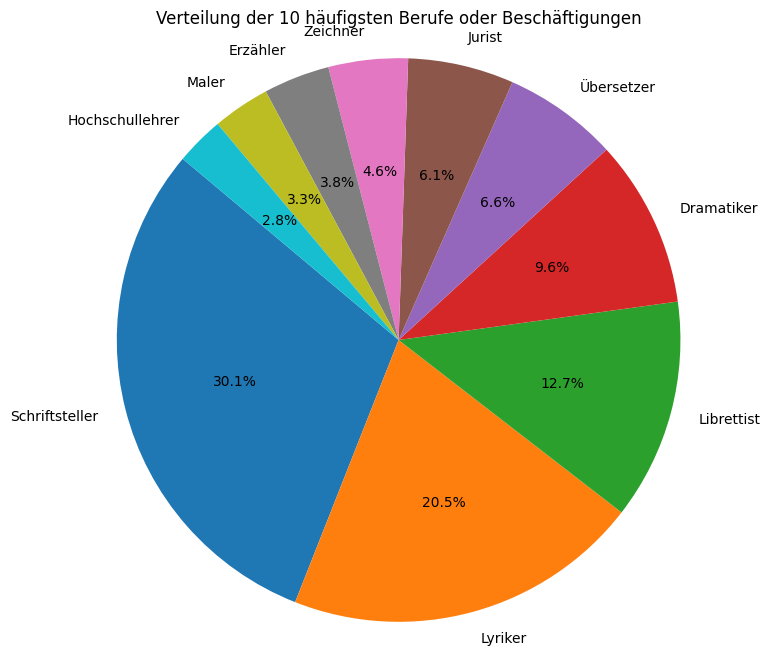

In [11]:
# Beruf oder Beschäftigung
beruf_beschaeftigung_counts = df['Beruf oder Beschäftigung'].value_counts().head(10)  # Nur die 10 häufigsten Werte

# Kreisdiagramm erstellen
plt.figure(figsize=(8, 8))
plt.pie(beruf_beschaeftigung_counts, labels=beruf_beschaeftigung_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Verteilung der 10 häufigsten Berufe oder Beschäftigungen')
plt.axis('equal')  
plt.show()


# DNBLab Tutorial: Daten bereinigen und zusammenführen mittels OpenRefine

## Part 1: Datenbezug mittels SRU-Schnittstelle

Als Datenbasis dienen die Metadaten des Digitalisierungsprojektes "100 Bände Klassik". Es enthält namhafte klassische Werke u.a. von Theodor Fontane, J.W. von Goethe und Rainer Maria Rilke und eignet sich daher besonders für einen ersten Einstieg in die Datenanreicherung, da die AutorInnen bereits umfassende Einträge in der GND haben. 

Die Daten werden mittels SRU-Schnittstelle bezogen und zur weiteren Verarbeitung in einer csv-Datei gespeichert. 

## Einrichten der Arbeitsumgebung

Um die Arbeitsumgebung für die folgenden Schritte passend einzurichten, sollten zunächst die benötigten Python-Bibliotheken importiert werden. Für Anfragen über die SRU-Schnittstelle wird `Requests` https://docs.python-requests.org/en/latest/ und zur Verarbeitung der XML-Daten `etree` https://docs.python.org/3/library/xml.etree.elementtree.html verwendet. Mit `Pandas` https://pandas.pydata.org/ können Elemente aus dem MARC21-Format ausgelesen werden.

In [1]:
import requests
from bs4 import BeautifulSoup 
import unicodedata
from lxml import etree
import pandas as pd
import matplotlib.pyplot as plt

## SRU-Abfrage mit Ausgabe in MARC21-xml

Die Funktion `dnb_sru` nimmt den Paramter "query" der SRU-Abfrage entgegen und liefert alle Ergebnisse als eine Liste von Records aus. Bei mehr als 100 Records werden weitere Datensätze mit "&startRecord=101" abgerufen (mögliche Werte 1 bis 99.000). Weitere Informationen und Funktionen der SRU- Schnittstelle werden unter https://www.dnb.de/sru beschrieben.

In [2]:
def dnb_sru(query):
    base_url = "https://services.dnb.de/sru/dnb"
    params = {
        'recordSchema': 'MARC21-xml',
        'operation': 'searchRetrieve',
        'version': '1.1',
        'maximumRecords': '100',
        'query': query
    }

    r = requests.get(base_url, params=params)
    # Verwende den XML-Parser
    xml = BeautifulSoup(r.content, features="xml")
    records = xml.find_all('record', {'type': 'Bibliographic'})

    if len(records) < 100:
        return records
    else:
        num_records_fetched = 100  # Anzahl der abgerufenen Datensätze
        start_record = 101  # Startindex für die nächste Abfrage
        while num_records_fetched == 100:
            params.update({'startRecord': start_record})
            r = requests.get(base_url, params=params)
            # Verwende den XML-Parser 
            xml = BeautifulSoup(r.content, features="xml")
            new_records = xml.find_all('record', {'type': 'Bibliographic'})
            records += new_records
            start_record += 100
            num_records_fetched = len(new_records)

        return records

# Durchsuchen eines MARC-Feldes

Die Funktion `parse_records` nimmt als Parameter jeweils ein Record entgegen und sucht über xpath die gewünschte Informationen heraus und liefert diese als Dictionary zurück. Die Schlüssel-Werte-Paare können beliebig angepasst und erweitert werden. 

Tipp: Schauen Sie sich gern unsere Feldübersicht für MARC21 an. 
https://www.dnb.de/SharedDocs/Downloads/DE/Professionell/Services/efa2023HandoutInhalteInMarc.pdf?__blob=publicationFile&v=2 

In [3]:
def parse_record(record):
    ns = {"marc": "http://www.loc.gov/MARC21/slim"}
    xml = etree.fromstring(unicodedata.normalize("NFC", str(record)))

    def safe_xpath(xpath_expr):
        elements = xml.xpath(xpath_expr, namespaces=ns)
        return elements[0].text if elements else "unknown"

    # IDN
    idn = safe_xpath("marc:controlfield[@tag = '001']")

    # Titel
    titel = safe_xpath("marc:datafield[@tag = '245']/marc:subfield[@code = 'a']")

    # Erscheinungsjahr
    jahr = safe_xpath("marc:datafield[@tag = '264']/marc:subfield[@code = 'c']")

    # Verfasserangabe
    verfasser = safe_xpath("marc:datafield[@tag = '100']/marc:subfield[@code = 'a']")

    # GND-ID
    gnd_id = safe_xpath("marc:datafield[@tag = '100']/marc:subfield[@code = '0']")

    # URN
    urn = safe_xpath("marc:datafield[@tag = '856']/marc:subfield[@code = 'u']")

    # Verlag
    verlag = safe_xpath("marc:datafield[@tag = '264']/marc:subfield[@code = 'b']")

    # Verlagsort
    verlagsort = safe_xpath("marc:datafield[@tag = '264']/marc:subfield[@code = 'a']")

    meta_dict = {
        "idn": idn,
        "titel": titel,
        "jahr": jahr,
        "verfasser": verfasser,
        "gnd_id": gnd_id,
        "urn": urn,
        "verlag": verlag,
        "verlagsort": verlagsort
    }

    return meta_dict


Das Digitalisierungsprojekt "100 Bände Klassik" kann mt dem Projektcode "d002" als Datenset abgefragt und die Ergebnismenge ausgegeben werden.

In [4]:
records = dnb_sru('cod=d002')
print(len(records), 'Ergebnisse')

108 Ergebnisse


## CSV Download

Für die Datenbereinigung und Datenanreicherung wird die Arbeit im csv-Format empfohlen. Hierfür werden die Suchergebnisse im Folgenden in einem Dataframe (Tabelle) ausgegeben und anschließend für die weitere Bearbeitung heruntergeladen. 

In [5]:
output = [parse_record(record) for record in records]
df = pd.DataFrame(output)
df

,idn,titel,jahr,verfasser,gnd_id,urn,verlag,verlagsort
0,1003104487,Egmont,[1946],"Goethe, Johann Wolfgang von",(DE-588)118540238,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Schöningh,Paderborn
1,999490184,Das Amulett,[1939],"Meyer, Conrad Ferdinand",(DE-588)118581775,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Verl. Dt. Volksbücher,Wiesbaden
2,1000047377,Der Struwwelpeter oder lustige Geschichten u...,[1939],"Hoffmann, Heinrich",(DE-588)11855249X,https://nbn-resolving.org/urn:nbn:de:101:2-201...,[Loewe],[Stuttgart]
3,1000290328,Der Zweikampf,1939,"Kleist, Heinrich von",(DE-588)118563076,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Kohlhammer,Stuttgart
4,99962461X,Heidi,1939,"Spyri, Johanna",(DE-588)118616455,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Rascher,Zürich
...,...,...,...,...,...,...,...,...
103,1000746348,Leyer und Schwerdt,1913,"Körner, Theodor",(DE-588)118713507,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Morawe & Scheffelt,Berlin
104,100003917X,Schillers Wallenstein,[1913],"Schiller, Friedrich",(DE-588)118607626,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Dt. Bibliothek,Berlin
105,1000062104,Vor dem Sturm,1913,"Fontane, Theodor",(DE-588)118534262,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Cotta,Stuttgart
106,1000775615,Der Tod des Tizian,[1912],"Hofmannsthal, Hugo von",(DE-588)118552759,https://nbn-resolving.org/urn:nbn:de:101:2-201...,Insel-Verl.,Leipzig


In [6]:
# DataFrame als CSV speichern
df.to_csv('Klassik.csv', index=False)

# Part 2: Datenbereinigung 

In unserer Ausgabe fällt auf, dass viele Titel mit eckigen Klammern ausgegeben werden oder zusätzliche Informationen enthalten, die nicht für die Analysen relevant sind. Grundlage für jede Datenanalyse sind normierte und bereinigte Ausgangsdaten. Diese können wir mittels OpenRefine bereinigen. OpenRefine ist ein Tool zur Datenbereinigung und Datenaufbereitung. Es kann mit sehr großen Datenmengen und mit diversen Formaten umgehen, zb.: .csv, .xml, .json etc. und eignet sich somit gut für die Analyse unserer Metadaten. 

Für die Datenbereinigung wird die Open-Source-Software OpenRefine eingesetzt. Eine lokale Installation (https://openrefine.org/download) wird empfohlen. Alternativ kann OpenRefine in der Webumgebung Binder gestartet werden: https://mybinder.org/v2/gh/innovationOUtside/nb_serverproxy_openrefine/main?urlpath=openrefine 

Bitte beachten Sie, dass die Ladezeiten der Online-Instanz stark variieren können.

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/1_Datenimport.png)

Folgende Felder sollen für eine exemplarische Analyse bereinigt werden. Dafür nutzen wir GREL-Funktionen, um die Werte zu extrahieren. GREL-Funktionen arbeiten mit regulären Ausdrücken. Die genauen Bezeichnungen kann man im Handbuch von OpenRefine nachlesen. "GREL" steht für "General Refine Expression Language" und bezieht sich auf die Ausdruckssprache, die in OpenRefine verwendet wird. Siehe: https://openrefine.org/docs/manual/grelfunctions 

**Erscheinungsjahr** 
- `value.find(/(\b\d{4}\b)/)[0]`
- Diese GREL-Funktion extrahiert das erste vierstellige Jahr, das in einer Zeichenkette gefunden wird. Dabei wird nach einer vierstelligen Zahl (z.B. "2024") gesucht und diese als Ergebnis zurückgegeben. 
- Hierfür wählen wir im Drop-Down Menü der Spalte den Befehl EDIT CELLS - Transform. Nun können wir unsere GREL-Expression eingeben. 







![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/2_Edit_Cells.JPG)

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/3_Year.png)


**GND ID** 
- `value.replace(/\(DE-588\)/, "").trim()`
- Diese GREL-Funktion entfernt den Text "(DE-588)" aus einer Zeichenkette und entfernt anschließend überflüssige Leerzeichen am Anfang oder Ende der Zeichenkette. Das Ergebnis ist die bereinigte GND-ID ohne den Präfix "(DE-588)".

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/4_GND.JPG)

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/5_GNDT.JPG)


**Verlagsort**

- Um die Verlagsorte zu bereinigen, nutzen wir eine andere Möglichkeit der Bearbeitung von Open Refine. Zuerst werden wir die Verlagsorte vorselektieren. Dieser Weg eignet sich besonders bei kleinen Datenmengen. 
- Wir wählen im Drop-Down-Menü das Feld `Facetten - Custom Facet`

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/6_Verlag.JPG)


- In einem Popup sehen wir nun eine Liste aller Verlagsorte. Diese bestätigen wir mit OK. 

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/7_customfacet.JPG)


- Daraufhin erscheint am linken Bildrand eine Liste. Wir suchen nun nach abweichenden Verlagsnamen und fügen sie mittels `include` zur Liste hinzu.


![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/8_Include.JPG)


- Die dadurch gebildete Facette sollte nun angezeigt werden.
- Mittels Mouse-Over und `Edit` gelangen wir zu dem einzelnen Value. 


![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/9_edit.JPG)


- Dieser wird nun in den bereinigten Verlagsort, zb.: Berlin umbenannt und mittels `Apply to all identical cells` wird jeder gleichnamige Value dieser Orte zu Berlin normiert. Diese Variante eignet sich bei überschaubaren Datenmengen.
- Zur Entfernung der Filter einfach `reset` in der rechten Spalte wählen 

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/10_apply.JPG)


# Part 3: Datenanreicherung mittels Open Refine

In der Gemeinsamen Normdatei (GND) finden wir viele Informationen zu Personen, Werken und Orten. Dort sind unter anderem Informationen zu Berufen, Beziehungen, Sterbe- und Geburtsdaten sowie Wirkungsdaten und Orte verzeichnet. Für unsere exemplarische Analyse reichern wir die Spalte `verfasser`mit Informationen aus der GND an. 

Folgende Felder sollen angereichert werden: 
- Geburtsdatum
- Geburtsort
- Liste der Berufe der Person

Weitere Felder. Informieren Sie sich dafür im GND Explorer und fügen Sie ein Feld Ihrer Wahl hinzu:  https://explore.gnd.network/

- Für die Datenanreicherung wählen wir die Spalte `gnd_id` 
- Unter dem Punkt `Reconcile` finden wir den Punkt `Start Reconciling`


![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/11_reconcile.JPG)

- Anschließend den Punkt `Add Standard Service` wählen
- Zum Abgleich nutzen wir `https://lobid.org/gnd/reconcile/`
- Mit `Add Service` bestätigen
- Fenster mit "Cancel" schließen

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/13_lobid.JPG)

- Nach dem Einrichten des Standard Service können wir nun über `Reconcile` `Use Values as Identifiers` die Verknüpfung mit der GND herstellen
- Wir wählen unseren Service `GND reconcililation  for OpenRefine`

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/14_values.JPG)

- Die Daten erscheinen nun als Links. Beim Mouse-Over werden Informationen über den Autor angezeigt.
- Um zusätzliche Spalten zu erstellen, wählen wir nun unsere Spalte `gnd_id` `Edit column` `Add column from reconciled values...` und können anschließend unsere gewünschten Werte wählen


![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/15_revalues.JPG)

![Transform](https://raw.githubusercontent.com/deutsche-nationalbibliothek/dnblab/main/images/16_new.JPG)

- `OK` anwählen und einen Moment warten, während Open Refine die neuen Spalten erstellt.
- Im Drop-Down Menü unter Exportieren kann die Datei als .csv Datei exportiert werden. 

## Part 4: Datenanalyse

## Daten einlesen

Nachdem die Daten bereinigt und mit Daten aus der GND angereichert wurden, führen wir eine exemplarische Analyse auf unseren angereicherten Daten durch. Zuerst wird die csv-Datei importiert und als Dataframe (Tabelle) ausgegeben. Der Dataframe bildet die Basis für die weiteren Bearbeitungen. 

Da die Zeilen in Open Refine untereinander angezeigt werden, findet sich bei leeren Werten die Bezeichnung "NaN".

In [7]:
# Passe den Dateinamen entsprechend an
filename = 'Klassik_angereichert.csv'

# Daten aus der CSV-Datei in DataFrame laden
df = pd.read_csv(filename)

df


FileNotFoundError: [Errno 2] No such file or directory: 'Klassik_angereichert.csv'

## Vertretene AutorInnen

Zuerst soll herausgefunden werden, welche AutorInnen mit wie vielen Werken in dem Datenset vorhanden sind. Dazu zählen wir die values in dem gegebenen Dataframe.

In [32]:
# Anzahl der Werke pro AutorIn zählen und in ein DataFrame konvertieren
anzahl_werke_pro_autor_df = pd.DataFrame(df['verfasser'].value_counts())

# Umbenennen der Spalte in 'Anzahl der Werke'
anzahl_werke_pro_autor_df.columns = ['Anzahl der Werke']

# Anzeige des DataFrames
print("Anzahl der Werke pro AutorIn:")
print(anzahl_werke_pro_autor_df)

Anzahl der Werke pro AutorIn:
                                              Anzahl der Werke
verfasser                                                     
Kleist, Heinrich von                                       7
Goethe, Johann Wolfgang von                                6
Fontane, Theodor                                             6
Meyer, Conrad Ferdinand                                      5
Keller, Gottfried                                            5
Eichendorff, Joseph von                                    4
Schiller, Friedrich                                          4
Hoffmann, E. T. A.                                           4
Storm, Theodor                                               4
Wassermann, Jakob                                            3
Stifter, Adalbert                                            3
Mörike, Eduard                                               3
Gotthelf, Jeremias                                           3
Tieck, Ludwig            

## Erscheinungsjahre visualisieren 

Die Erscheinungsjahre der Publikationen sollen grafisch dargestellt werden.
Testen Sie, was passiert, wenn Sie die Werte unter plt.figure(figsize=(15, 8)) & plt.hist(years, bins=50, ändern. 

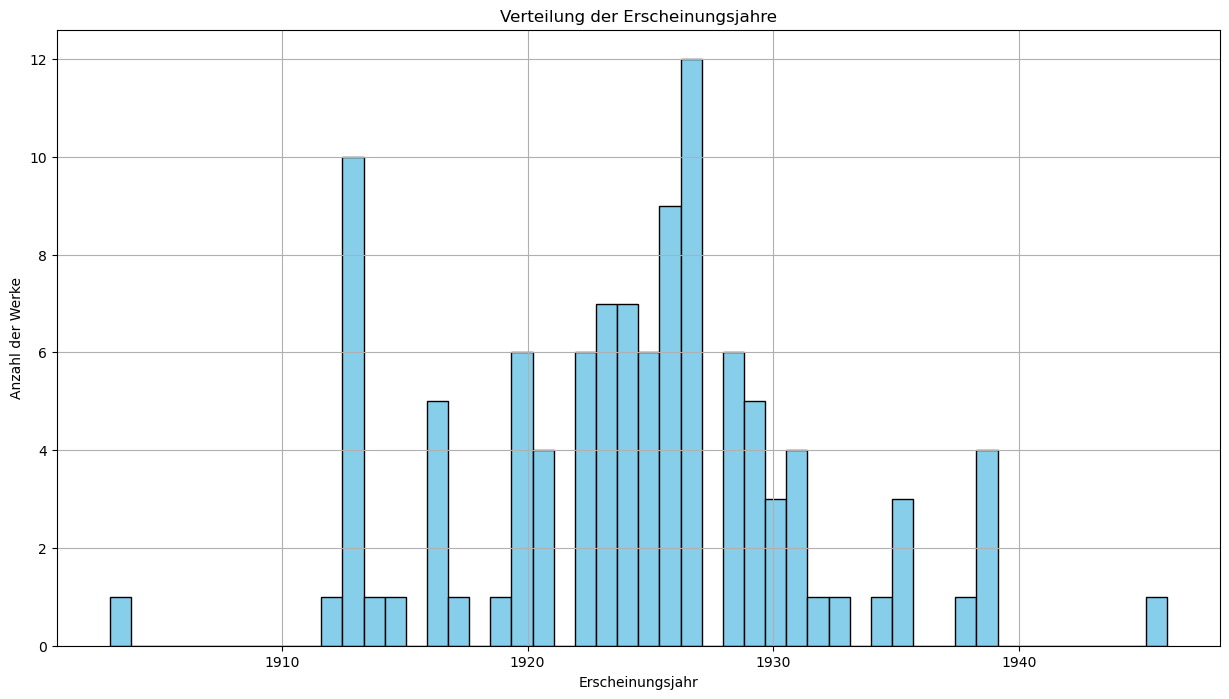

In [33]:
# Erscheinungsjahre aus der Spalte 'jahr' im DataFrame df extrahieren
years = df['jahr']

# Histogramm erstellen
plt.figure(figsize=(15, 8)) # definiert die Größe des Diagramms 
plt.hist(years, bins=50, color='skyblue', edgecolor='black')  # Anzahl der Bins anpassen, um die gewünschte Granularität zu erreichen
plt.title('Verteilung der Erscheinungsjahre')
plt.xlabel('Erscheinungsjahr')
plt.ylabel('Anzahl der Werke')
plt.grid(True)
plt.show()


# Berufe visualisieren 

Was sind die 10 häufigsten Berufe, die unsere enthaltenen AutorInnen ausüben? Dazu können wir mit der matplotlib.pyplot ein Kreisdiagramm erstellen. Aufgrund der Diversität der Berufe wird der Datenbestand auf die Top-10-Berufe beschränkt. 
Im Codefeld beruf_beschaeftigung_counts = df['Beruf oder Beschäftigung'].value_counts().head(10) lässt sich der Wert 10 beliebig anpassen. Hier sollte man jedoch die Auswirkungen auf die Übersichtlichkeit beachten. 

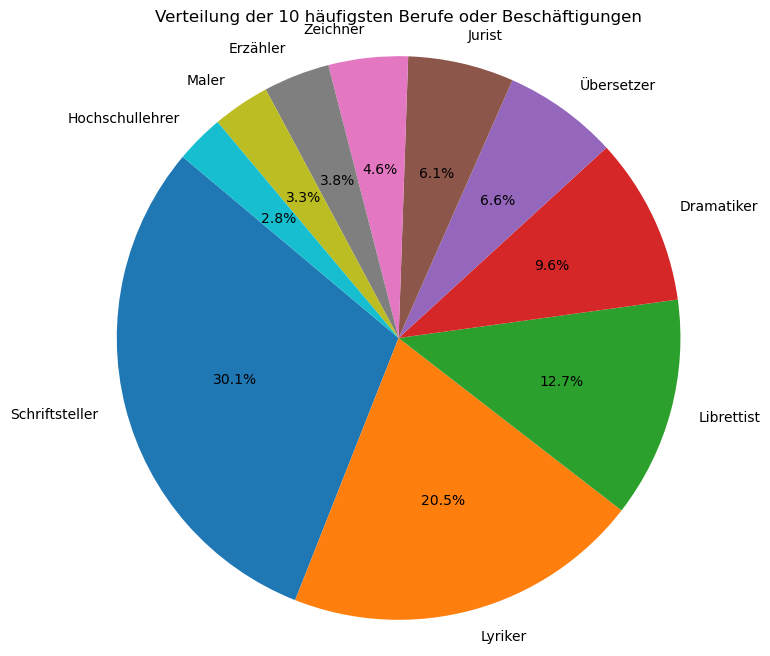

In [34]:
# Beruf oder Beschäftigung
beruf_beschaeftigung_counts = df['Beruf oder Beschäftigung'].value_counts().head(10)  # Nur die 10 häufigsten Werte

# Kreisdiagramm erstellen
plt.figure(figsize=(8, 8))
plt.pie(beruf_beschaeftigung_counts, labels=beruf_beschaeftigung_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Verteilung der 10 häufigsten Berufe oder Beschäftigungen')
plt.axis('equal')  
plt.show()
